# American-Sign-Language

Neste projeto, classificaremos os símbolos da língua gestual por meio da **Rede Neural Convolucional (CNN)**. Após o treinamento bem-sucedido do modelo CNN, o alfabeto correspondente de um símbolo de linguagem gestual será previsto. Avaliaremos o desempenho de classificação de nosso modelo usando as **matrizes de confusão** *normalizadas* e *não normalizadas*. Por fim, obteremos a pontuação de **precisão da classificação** do modelo CNN.



### Conjunto de dados

Neste projeto, usamos o conjunto de dados *American Sign Language* (ASL) fornecido pelo MNIST, disponível publicamente no Kaggle. Este conjunto de dados contém 27455 imagens de treinamento e 7172 imagens de teste, todas com formato de 28x28 pixels com valores em tons de cinza entre 0-255. Essas imagens pertencem às 24 classes do alfabeto americano, começando de A a Y (sem rótulos da classe para J (9) e para Z (25) por causa dos movimentos dos gestos).

O conjunto de dados no Kaggle está disponível no formato CSV, onde os dados de treinamento têm 27455 linhas e 785 colunas e os dados de teste têm 7172 linhas e 785 colunas. A primeira coluna do conjunto de dados representa o rótulo da classe da imagem e as 784 colunas restantes representam os 28x28 pixels.

<center><img src="images/american_sign_language.png" style="width:250px;height:150px;"></center>
<caption><center> Fig. 1: Alfabeto em língua gestual americana </center></caption>

##### Implementação de bibliotecas importantes

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

##### Leitura dos dados de treino e de teste dos ficheiros CSV

In [80]:
# obter os dados de treinamento
dataTrain = pd.read_csv('sign_mnist_train.csv')
# obter os rotulos dos dados de treinamento
yTrain = dataTrain['label'].values
yTrain2 = dataTrain['label'].values
# remover os rotulos dos dados de treinamento
dataTrain.drop('label', axis = 1, inplace = True)

# obter os dados de teste
dataTest = pd.read_csv('sign_mnist_test.csv')
# obter os rotulos dos dados de teste
yTest = dataTest['label'].values
yTest2 = dataTest['label'].values
#remover os rotulos dos dados de teste
dataTest.drop('label', axis = 1, inplace = True)
# verificar os dados de teste para verificar os rotulos de classe e as colunas que representam os pixeis
dataTest.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


##### Especificar os rótulos de classe para as imagens

In [143]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K' , 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X','Y']

In [144]:
class_names2 = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K' , 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X','Y']

##### Histograma com o número de vezes que aparece uma letra do alfabeto, onde "A" corresponde à classe 0, "B" à classe 1 e assim sucessivamente

<AxesSubplot:xlabel='classes', ylabel='count'>

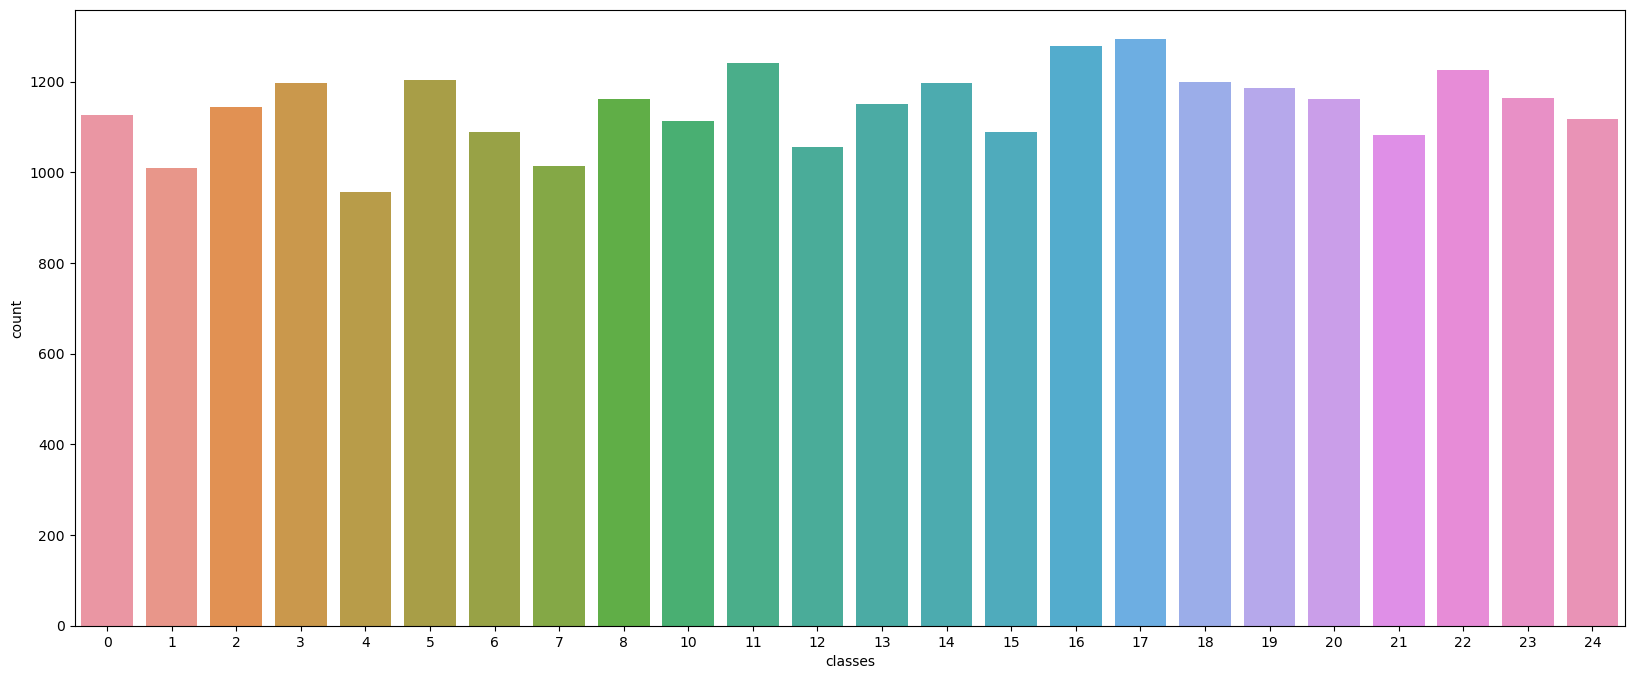

In [123]:
plt.figure(figsize = (20,8))
plt.xlabel('classes')
sns.countplot(x = yTrain)

##### Converter os dados lidos para matrizes, para posterior processamento dos dados

In [21]:
# converter os dados de treinamento para um array
xTrain = dataTrain.values

# converter os dados de teste para um array
xTest = dataTest.values

# converter os dados dos rotulos para um array
unique_val = np.array(yTrain)
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

##### ???????????????????????????????????

In [22]:
xTrain = np.array(xTrain.reshape(-1,28,28,1))
xTest = np.array(xTest.reshape(-1,28,28,1))
print(xTrain.shape)
print(xTest.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


> "-1" especifica que esta dimensão no eixo atual deve ser calculada dinamicamente de acordo com a regra de que os elementos totais do tensor permanecem inalterados. Isso nos permite tratar batch_size (parâmetro com valor -1) como um hiperparâmetro que podemos ajustar.

##### Converter os rótulos das classes em rótulos binários (onde "1" significa que pertence e "0" que não pertence à classe)

In [23]:
lbTrain = LabelBinarizer()
lbTest = LabelBinarizer()
yTrain = lbTrain.fit_transform(yTrain)
yTest = lbTest.fit_transform(yTest)

##### Visualizar algumas imagens do conjunto de dados de treinamento

Text(0.5, 0.98, 'Some images from train data set')

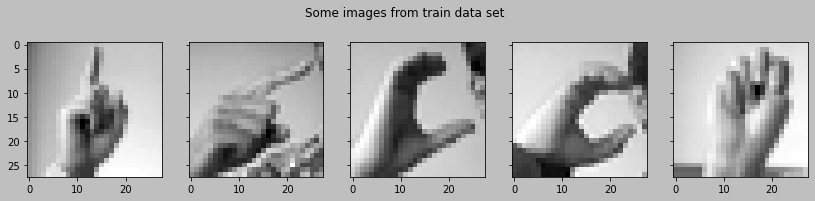

In [35]:
plt.style.use('grayscale')
fig, axs = plt.subplots(1, 5, figsize=(14, 3), sharey=True)
for i in range(5): 
    axs[i].imshow(xTrain[i].reshape(28,28),cmap='gray')
fig.suptitle('Some images from train data set')

### Conjunto de dados Definir o modelo CNN (Convolutional Neural Network)

In [26]:
batch_size = 128
# number of classes
num_classes = 24
epochs = 100

In [27]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(num_classes, activation = 'softmax'))

> A partir da definição da documentação tensorflow.keras, o modelo **Sequencial** é uma stack linear de camadas.

> **kernel_size** é um *inteiro* que especifica o mesmo valor para todas as dimensões espaciais, ou *tuplo/lista* de 2 inteiros, que especifica a altura e largura da janela de convolução 2D.

> **activation** é uma função de ativação para ser aplicada.

> **input_shape** é um tensor com a forma: batch_shape + (linhas, colunas, canais), quando data_format = 'canais_last'.

##### Compilar o modelo de CNN (Convolutional Neural Network)

In [28]:
model.compile(loss = tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(), metrics=['accuracy'])

##### Treinar o modelo CNN (Convolutional Neural Network)

In [29]:
history = model.fit(xTrain, yTrain, validation_data = (xTest, yTest), epochs=epochs, batch_size=batch_size)

Epoch 1/100
215/215 [==============================] - 23s 101ms/step - loss: 3.6738 - accuracy: 0.1300 - val_loss: 0.9684 - val_accuracy: 0.7132
Epoch 2/100
215/215 [==============================] - 20s 93ms/step - loss: 1.0817 - accuracy: 0.6425 - val_loss: 0.3959 - val_accuracy: 0.8798
Epoch 3/100
215/215 [==============================] - 19s 89ms/step - loss: 0.4770 - accuracy: 0.8409 - val_loss: 0.2738 - val_accuracy: 0.9237
Epoch 4/100
215/215 [==============================] - 18s 83ms/step - loss: 0.2549 - accuracy: 0.9162 - val_loss: 0.1617 - val_accuracy: 0.9410
Epoch 5/100
215/215 [==============================] - 18s 86ms/step - loss: 0.1619 - accuracy: 0.9470 - val_loss: 0.1644 - val_accuracy: 0.9508
Epoch 6/100
215/215 [==============================] - 19s 87ms/step - loss: 0.1173 - accuracy: 0.9611 - val_loss: 0.1550 - val_accuracy: 0.9446
Epoch 7/100
215/215 [==============================] - 19s 87ms/step - loss: 0.0931 - accuracy: 0.9724 - val_loss: 0.0873 - val_a

In [62]:
model = tensorflow.keras.models.load_model('sign_language')

##### Visualizar o desempenho do treinamento do modelo CNN

Text(0.5, 1.0, 'Evolução de precisão (Accurary Evolution)')

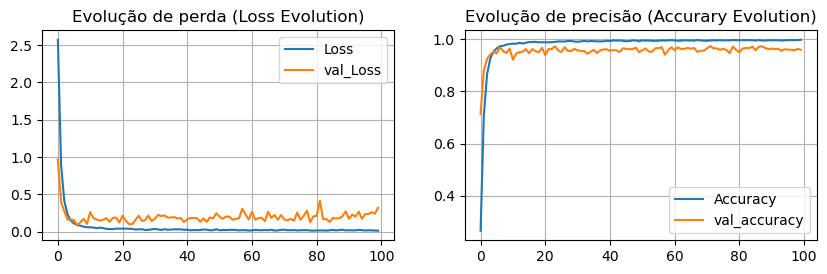

In [132]:
plt.style.use('default')
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'val_Loss')
plt.legend()
plt.grid()
plt.title('Evolução de perda (Loss Evolution)')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.grid()
plt.title('Evolução de precisão (Accurary Evolution)')

##### Usar o modelo CNN treinado para fazer previsões sobre os dados de teste invisíveis

In [134]:
predicted_classes = model.predict_classes (xTest)

##### Visualização das previsoes dos rótulos das classes para as imagens de teste do modelo da CNN

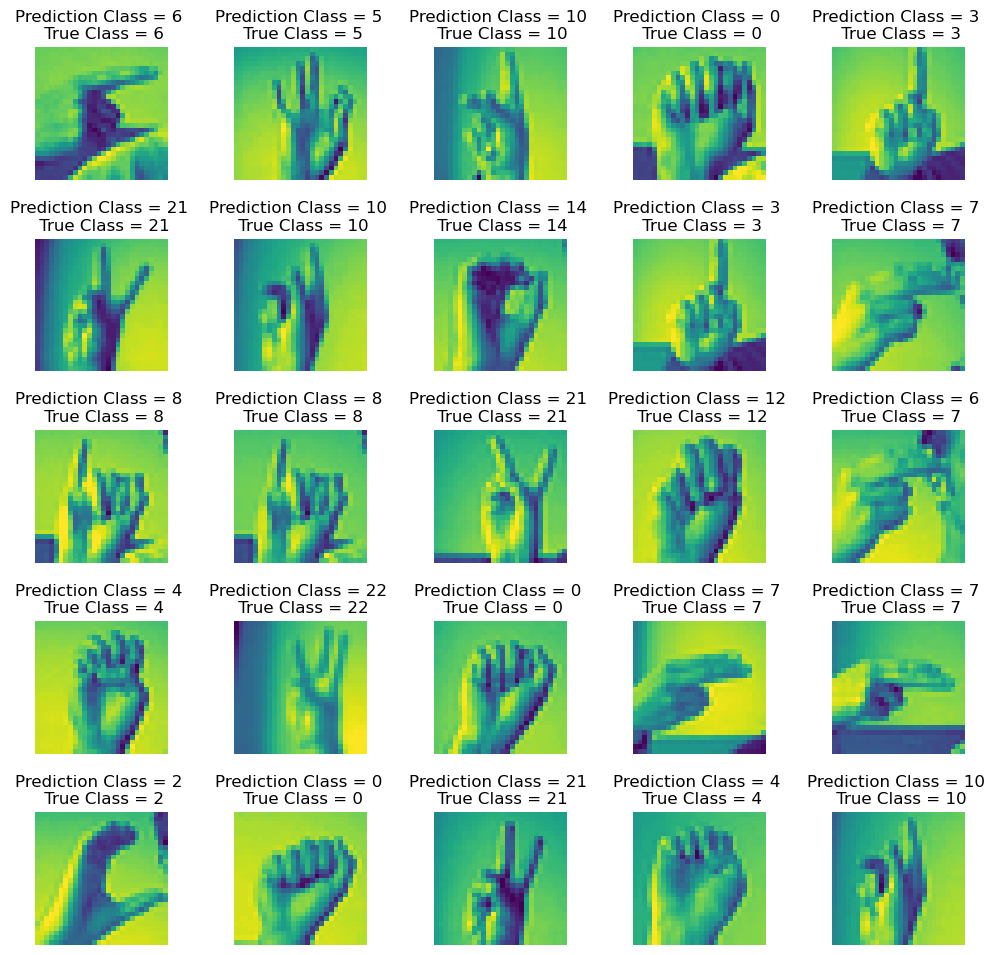

In [135]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, L * W):
    if (predicted_classes[i] >= 9):
        axes[i].imshow(xTest[i].reshape(28,28)) 
        axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(predicted_classes[i]+1, yTest2[i])) 
        axes[i].axis('off') 
    else:
        axes[i].imshow(xTest[i].reshape(28,28)) 
        axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(predicted_classes[i], yTest2[i])) 
        axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5)

##### Visualização do relatório completo de classificação, usando matrizes de confusão normalizadas e não normalizadas

In [136]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(yTest, predicted_classes)

##### Definir a função para o gráfico da matriz de confusão

In [137]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # matriz de confusao
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # visualizacao
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, ylabel='True label', xlabel='Predicted label')

    # girar os rótulos e definir o alinhamento
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # loop sobre dimensoes de dados e criar anotacoes de texto
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

##### Matriz de confusão não normalizada

Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

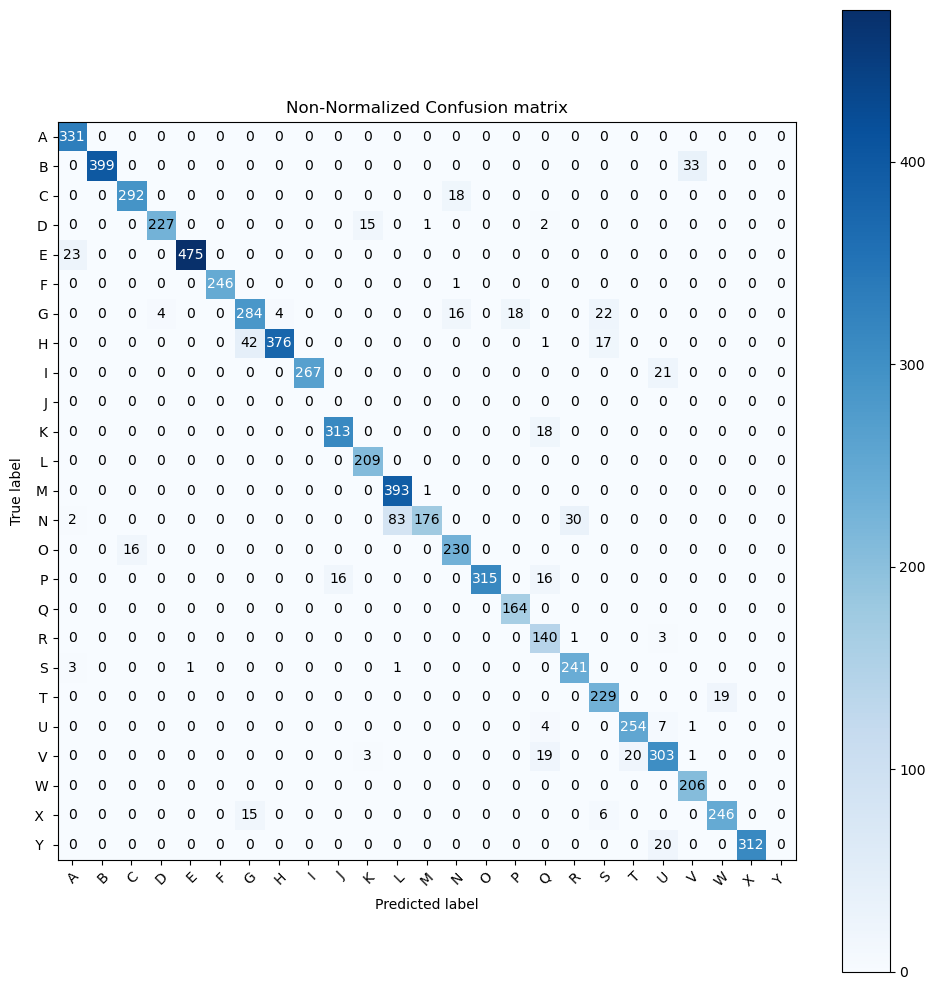

In [138]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(yTest, predicted_classes, classes = class_names, title='Non-Normalized Confusion matrix')
plt.show()

##### Matriz de confusão normalizada

<ipython-input-137-92740214017a>:11: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


<Figure size 3500x3500 with 0 Axes>

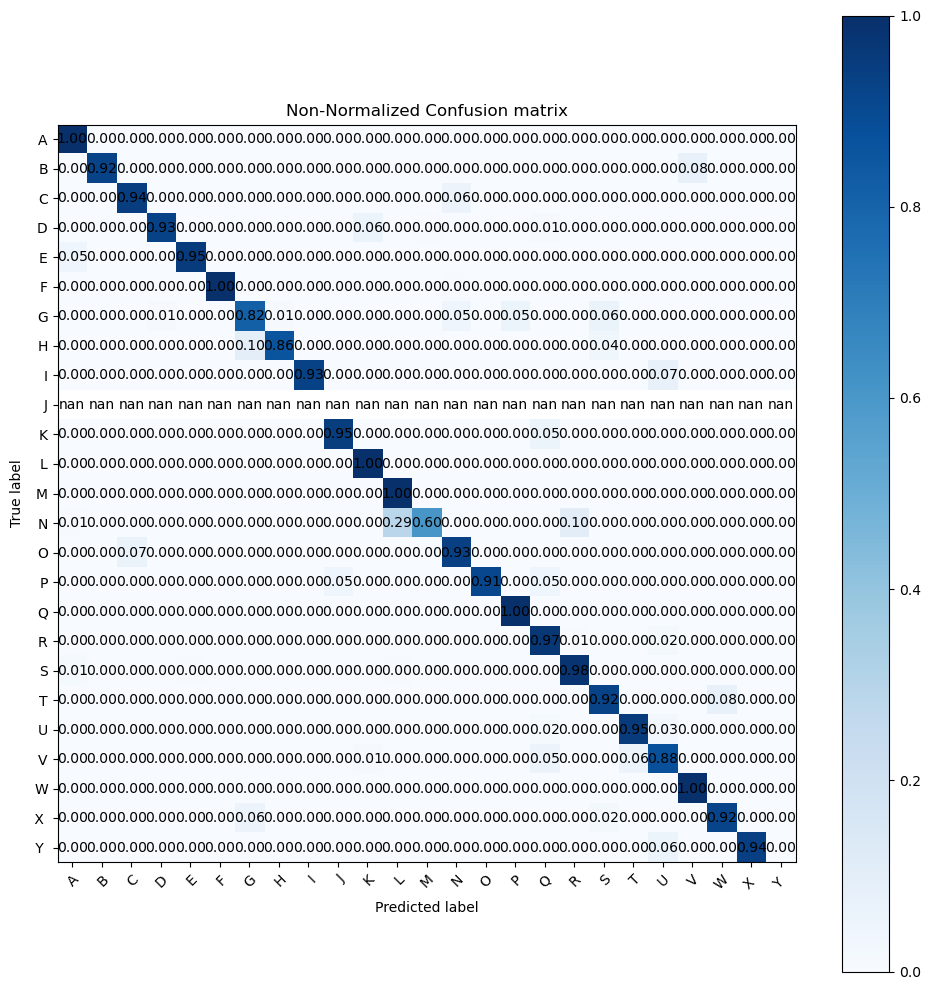

In [139]:
plt.figure(figsize=(35,35))
plot_confusion_matrix(yTest, predicted_classes, classes = class_names, normalize=True, title='Non-Normalized Confusion matrix')
plt.show()

##### Pontuação média de precisão da classificação

In [140]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(yTest, predicted_classes)
print('Accuracy Score = ',acc_score)

Accuracy Score =  0.40532626882320133


In [ ]:
def classify(image):
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    proba = model.predict(image)
    idx = np.argmax(proba)
    return class_names[idx]

In [ ]:
classify(xTrain[0]*255)

In [ ]:
print(yTrain[0])

In [ ]:
#RITA, isto é um experimento para provar que se mudarmos alguns pixeis da imagem, a Letra é a mesma,
#mas se mudarmos pixeis a mais a imagem diz que é outra letra.
arr = []
arr = xTrain[0].copy()
arr[0] = 90
arr[1] = 90
#arr[5] = 90

In [ ]:
classify(arr*255) # igual a xTrain[0] mas com alterações dos valores do array xTrain[0]